In [4]:
import numpy as np
from scipy.io import loadmat, wavfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from librosa import istft
from scipy.signal import resample, resample_poly
from resampy import resample as resample2
import copy
import random
import IPython.display as ipd
import json
from sklearn import linear_model
import pickle as pkl
import time
from sklearn.linear_model import LinearRegression

from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from data_utils import norm_power_wav, envelope, unit_power, true_SNR, daniel_env, load_wav
import torch
import data_utils

from sep_eval import sep_eval
from model_stft import InfoComMask
import torch 
from train_test import sSDR

import seaborn as sns
import librosa

import pandas as pd
import sys
from tqdm import tqdm
import statannot 
import csv

In [22]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
def load_info_model(load, base_dir='/Data/Dropbox/PhD/Projects/brain-informed-source-separation', pit=False):
    json_dir = base_dir + '/logs2/' + load
    with open(json_dir + '/architecture.json', 'r') as fff:
        p = json.load(fff)
        load_path = json_dir

        model = InfoComMask(n_fft=p['nfft'], kernel=(p['kf'], p['kt']), causal=p['causal'],
                                layers=p['layers'], stacks=p['stacks'], verbose=False, use_pit=pit)

        model.load_state_dict(torch.load(load_path + '/model_weights.pt'))
        _ = model.eval()
        return model, p

In [5]:
# 201908094705_ICM_baseline_00_1_std_125_sep_NC
# 201908114859_ICM_baseline_00_1_std_125_sep_C
# 201909120235_ICM_baseline_PIT_00_1_dan_125_sep_C
# 201909120235_ICM_baseline_PIT_00_1_dan_125_sep_NC
PIT = False
_model, _p = load_info_model('201908122515_ICM_noise_50_40_std_125_sep_NC', pit=PIT)

In [6]:
# verbose
def do_single_model(_model, pit=False, n_samples=1000, env='std'):
    data_dir = '/Data/DATASETS/WSJ/'
    code_dir = '/Data/Dropbox/PhD/Projects/'
    base_dir = code_dir + 'brain-informed-source-separation'
    validation_data_path = data_dir + 'danish_english_singles_v4.h5'
    data_verbose = data_utils.DatasetSTFTv5(validation_data_path,  task='valid', env=env, use_pit=pit)

    sdr, stoi = [], []

    for i in tqdm(range(n_samples)):
        if pit:
            mix_tensor, s1_tensor, s2_tensor, h_tensor = data_verbose[i]
            s2 = s2_tensor.unsqueeze(0)
        else:
            mix_tensor, s1_tensor, h_tensor = data_verbose[i]

        mix = mix_tensor.unsqueeze(0)
        s1 = s1_tensor.unsqueeze(0)
        env = h_tensor.unsqueeze(0)

        if pit:
            recon1, recon2 = _model([mix, env])
            
            a = sep_eval.sdr(recon1.squeeze().data.numpy(), s1.squeeze().data.numpy(), average=False)
            c = sep_eval.sdr(recon1.squeeze().data.numpy(), s2.squeeze().data.numpy(), average=False)
            sdr.append(max(a, c))
            
            a = sep_eval.stoi(recon1.squeeze().data.numpy(), s1.squeeze().data.numpy(), average=False)
            c = sep_eval.stoi(recon1.squeeze().data.numpy(), s2.squeeze().data.numpy(), average=False)
            stoi.append(max(a, c))
        else:
            recon = _model([mix, env])
            
            a = sep_eval.sdr(recon.squeeze().data.numpy(), s1.squeeze().data.numpy(), average=False)
            sdr.append(a)
            
            a = sep_eval.stoi(recon.squeeze().data.numpy(), s1.squeeze().data.numpy(), average=False)
            stoi.append(a)
            
    return sdr, stoi

In [43]:
with open('versus_PIT.csv', 'w') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    header = ["model", "causal", "pit", "sdr", "stoi"]
    file_writer.writerow(header)

In [16]:
model1, _p = load_info_model('201908094705_ICM_baseline_00_1_std_125_sep_NC', pit=False)
model2, _p = load_info_model('201908114859_ICM_baseline_00_1_std_125_sep_C', pit=False)
model3, _p = load_info_model('201909120235_ICM_baseline_PIT_00_1_dan_125_sep_NC', pit=True)
model4, _p = load_info_model('201909120235_ICM_baseline_PIT_00_1_dan_125_sep_C', pit=True)

In [17]:
res1 = do_single_model(model1, pit=False, env='std')
with open('versus_PIT.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res1):
        file_writer.writerow(['model1', 0, 0, a, b])
print(f"Baseline ENV NC {np.mean(res1[0]):.2f} || {np.std(res1[0]):.2f} || {np.median(res1[0]):.2f}")

100%|██████████| 1000/1000 [29:32<00:00,  1.96s/it]

Baseline ENV NC 14.08 || 3.83 || 13.97


In [18]:
res2 = do_single_model(model2, pit=False, env='std')
with open('versus_PIT.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res2):
        file_writer.writerow(['model2', 1, 0, a, b])
print(f"Baseline ENV C {np.mean(res2[0]):.2f} || {np.std(res2[0]):.2f} || {np.median(res2[0]):.2f}")

100%|██████████| 1000/1000 [33:54<00:00,  2.04s/it]

Baseline ENV C 13.12 || 3.83 || 13.06


In [19]:
res3 = do_single_model(model3, pit=True, env='dan')
with open('versus_PIT.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res3):
        file_writer.writerow(['model3', 0, 1, a, b])
print(f"Baseline PIT NC {np.mean(res3[0]):.2f} || {np.std(res3[0]):.2f} || {np.median(res3[0]):.2f}")

100%|██████████| 1000/1000 [36:23<00:00,  2.20s/it]

Baseline PIT NC 13.16 || 3.62 || 12.98


In [20]:
res4 = do_single_model(model4, pit=True, env='dan')
with open('versus_PIT.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res4):
        file_writer.writerow(['model4', 1, 1, a, b])
print(f"Baseline PIT C {np.mean(res4[0]):.2f} || {np.std(res4[0]):.2f} || {np.median(res4[0]):.2f}")

100%|██████████| 1000/1000 [38:24<00:00,  2.21s/it]

Baseline PIT C 12.85 || 3.71 || 12.79


# Just noise effect

In [7]:
model1, _p = load_info_model('201908122515_ICM_noise_50_40_std_125_sep_NC', pit=False)
model2, _p = load_info_model('201908052205_ICM_noise_50_40_std_125_sep_C', pit=False)

In [9]:
with open('caus_ncaus_noise.csv', 'w') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    header = ["model", "causal", "pit", "sdr", "stoi"]
    file_writer.writerow(header)

In [10]:
res1 = do_single_model(model1, pit=False, env='std')
with open('caus_ncaus_noise.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res1):
        file_writer.writerow(['model1', 0, 0, a, b])
print(f"Baseline ENV NC {np.mean(res1[0]):.2f} || {np.std(res1[0]):.2f} || {np.median(res1[0]):.2f}")

100%|██████████| 1000/1000 [33:40<00:00,  1.85s/it]

Baseline ENV NC 12.48 || 4.03 || 12.46


In [11]:
res1 = do_single_model(model2, pit=False, env='std')
with open('caus_ncaus_noise.csv', 'a') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    for a, b in zip(*res1):
        file_writer.writerow(['model2', 1, 0, a, b])
print(f"Baseline ENV C {np.mean(res1[0]):.2f} || {np.std(res1[0]):.2f} || {np.median(res1[0]):.2f}")

100%|██████████| 1000/1000 [33:58<00:00,  2.52s/it]

Baseline ENV C 12.00 || 3.99 || 11.97


In [26]:
pl = sns.husl_palette(10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = pd.read_csv('versus_PIT.csv')

data["cc"] = ["Causal" if a == 1 else "Non-causal" for a in data["causal"]]
data["pp"] = ["PIT" if a == 1 else "Informed" for a in data["pit"]]

ax = sns.violinplot(data=data, x='pp', y='sdr', hue='cc', palette=(pl[0], pl[7]), ax=ax)
ax = statannot.add_stat_annotation(ax, data, x='pp', y='sdr', hue='cc', 
                                  boxPairList=[(("Informed", "Non-causal"), ("Informed", "Causal")),
                                               (("Informed", "Non-causal"), ("PIT", "Non-causal")),
                                               (("Informed", "Causal"), ("PIT", "Causal")),
                                                                                       ],
                                test='Mann-Whitney', textFormat='star', loc='inside', verbose=0)

ax.set_xlabel("")
ax.set_ylabel("SDR (dB)")

ax.grid()
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.tight_layout()

plt.savefig("PIT_vs_INFORMED.pdf", transparent=True, bbox_inches="tight")

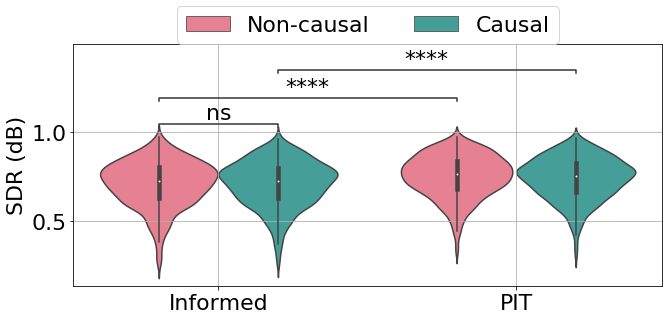

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = pd.read_csv('versus_PIT.csv')

data["cc"] = ["Causal" if a == 1 else "Non-causal" for a in data["causal"]]
data["pp"] = ["PIT" if a == 1 else "Informed" for a in data["pit"]]

ax = sns.violinplot(data=data, x='pp', y='stoi', hue='cc', palette=(pl[0], pl[7]), ax=ax)
ax = statannot.add_stat_annotation(ax, data, x='pp', y='stoi', hue='cc', 
                                  boxPairList=[(("Informed", "Non-causal"), ("Informed", "Causal")),
                                               (("Informed", "Non-causal"), ("PIT", "Non-causal")),
                                               (("Informed", "Causal"), ("PIT", "Causal")),
                                                                                       ],
                                test='Mann-Whitney', textFormat='star', loc='inside', verbose=0)

ax.set_xlabel("")
ax.set_ylabel("SDR (dB)")

ax.grid()
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.tight_layout()

# plt.savefig("PIT_vs_INFORMED.pdf", transparent=True, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = pd.read_csv('versus_PIT.csv')

data["cc"] = ["Causal" if a == 1 else "Non-causal" for a in data["causal"]]
data["pp"] = ["PIT" if a == 1 else "Informed" for a in data["pit"]]

ax = sns.violinplot(data=data, x='pp', y='stoi', hue='cc', palette='husl', ax=ax)
# ax = statannot.add_stat_annotation(ax, data, x='pp', y='sdr', hue='cc', 
#                                   boxPairList=[(("Informed", "Non-causal"), ("Informed", "Causal")),
#                                                (("Informed", "Non-causal"), ("PIT", "Non-causal")),
#                                                (("Informed", "Causal"), ("PIT", "Causal")),
#                                                                                        ],
#                                 test='Mann-Whitney', textFormat='star', loc='inside', verbose=0)

ax.set_xlabel("")
ax.set_ylabel("STOI")

ax.grid()
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.tight_layout()

# plt.savefig("PIT_vs_INFORMED.pdf", transparent=True, bbox_inches="tight")

In [83]:
print(data.groupby(by=["cc", "pp"])["stoi"].median())

cc          pp      
Causal      Informed    0.723907
            PIT         0.753278
Non-causal  Informed    0.724006
            PIT         0.762652
Name: stoi, dtype: float64


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data = pd.read_csv('caus_ncaus_noise.csv')

data["cc"] = ["Causal" if a == 1 else "Non-causal" for a in data["causal"]]

ax = sns.violinplot(data=data, x='cc', y='sdr', palette='husl', ax=ax)
ax = statannot.add_stat_annotation(ax, data, x='cc', y='sdr', 
                                  boxPairList=[( "Non-causal", "Causal")],
                                test='Mann-Whitney', textFormat='star', loc='inside', verbose=2)

ax.set_xlabel("")
ax.set_ylabel("SDR (dB)")

ax.grid()
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.tight_layout()
print(data.groupby(by=["cc"])["sdr"].median())

No handles with labels found to put in legend.


pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Non-causal v.s. Causal: MWW RankSum two-sided P_val=5.890e-03 U_stat=5.356e+05
cc
Causal        11.970858
Non-causal    12.458666
Name: sdr, dtype: float64
